# IMWUT Tobii Embedding Analysis

First-pass diagnostics for `trustME/data/processed/imwut_tobii`:
- Artifact and alignment checks
- Segment/QC/label/subject statistics
- Embedding-space sanity checks
- 2D visualization and separability diagnostics
- Quick downstream baseline (linear probe)


Quick mode is available via `QUICK_SANITY_MODE` in the config cell.


In [52]:
from pathlib import Path
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid

warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (10, 5)
RNG = 42


In [53]:
# Quick sanity mode (set True for fast notebook iteration)
QUICK_SANITY_MODE = False
QUICK_MAX_SEGMENTS = 3000
QUICK_RANDOM_SEED = 42

# Optional: restrict to specific subjects in quick mode, e.g. ["s_001", "s_002"]
QUICK_SUBJECTS: list[str] | None = None # ["s_017"]

# Label scheme: 'task', 'binary', 'edr', or 'avm'
LABEL_SCHEME = 'binary'



In [54]:
# Paths
PROCESSED_DIR = Path('../data/processed/imwut_tobii').resolve()
META_PATH = PROCESSED_DIR / 'segments_metadata.parquet'
INPUTS_PATH = PROCESSED_DIR / 'moment_inputs.npz'
EMB_PATH = PROCESSED_DIR / 'moment_embeddings.npz'
MANIFEST_PATH = PROCESSED_DIR / 'manifest.json'

for p in [META_PATH, INPUTS_PATH, EMB_PATH, MANIFEST_PATH]:
    print(f'{p.name:25s} exists={p.exists()} size_mb={(p.stat().st_size/1024/1024 if p.exists() else 0):.2f}')


segments_metadata.parquet exists=True size_mb=0.53
moment_inputs.npz         exists=True size_mb=21.24
moment_embeddings.npz     exists=True size_mb=36.61
manifest.json             exists=True size_mb=0.00


In [55]:
# Load artifacts
meta = pd.read_parquet(META_PATH)
inputs = np.load(INPUTS_PATH, allow_pickle=False)
emb = np.load(EMB_PATH, allow_pickle=False)

x = inputs['x']
input_mask = inputs['input_mask']
in_seg_ids = inputs['segment_id'].astype(str)

X = emb['embeddings'].astype(np.float32)
emb_seg_ids = emb['segment_id'].astype(str)

with open(MANIFEST_PATH, 'r') as f:
    manifest = json.load(f)

print('meta shape:', meta.shape)
print('x shape:', x.shape, '| input_mask shape:', input_mask.shape)
print('embeddings shape:', X.shape)
print('manifest counts:', manifest.get('counts', {}))


meta shape: (17363, 16)
x shape: (10110, 4, 512) | input_mask shape: (10110, 512)
embeddings shape: (10110, 1024)
manifest counts: {'segments_dropped': 7253, 'segments_kept': 10110, 'segments_total_filtered': 17363}


In [56]:
# Integrity and alignment checks
kept = meta.loc[meta['kept']].copy()
dropped = meta.loc[~meta['kept']].copy()

print('kept segments:', len(kept))
print('dropped segments:', len(dropped))

assert len(in_seg_ids) == len(kept), 'moment_inputs rows must match kept segments'
assert len(emb_seg_ids) == X.shape[0], 'embedding ids must match embedding rows'
assert np.array_equal(in_seg_ids, emb_seg_ids), 'input and embedding segment_id ordering mismatch'
assert set(in_seg_ids) == set(kept['segment_id'].astype(str)), 'metadata kept ids mismatch'

# reorder kept metadata to embedding order for safe joins
kept = kept.set_index('segment_id').loc[emb_seg_ids].reset_index()

print('NaN in embeddings:', np.isnan(X).any())
print('Inf in embeddings:', np.isinf(X).any())
print('Zero-norm embeddings:', int((np.linalg.norm(X, axis=1) == 0).sum()))

if QUICK_SANITY_MODE:
    if QUICK_SUBJECTS:
        quick_subjects = set(QUICK_SUBJECTS)
        keep_mask = kept['Subject'].isin(quick_subjects).to_numpy()
        kept = kept.loc[keep_mask].reset_index(drop=True)
        X = X[keep_mask]
        in_seg_ids = in_seg_ids[keep_mask]
        emb_seg_ids = emb_seg_ids[keep_mask]
        x = x[keep_mask]
        input_mask = input_mask[keep_mask]

    if len(kept) > QUICK_MAX_SEGMENTS:
        rng = np.random.default_rng(QUICK_RANDOM_SEED)
        idx = np.sort(rng.choice(len(kept), size=QUICK_MAX_SEGMENTS, replace=False))
        kept = kept.iloc[idx].reset_index(drop=True)
        X = X[idx]
        in_seg_ids = in_seg_ids[idx]
        emb_seg_ids = emb_seg_ids[idx]
        x = x[idx]
        input_mask = input_mask[idx]

    print(f'QUICK_SANITY_MODE active: n={len(kept)} segments, subjects={kept["Subject"].nunique()}')

print('All checks passed.')


kept segments: 10110
dropped segments: 7253
NaN in embeddings: False
Inf in embeddings: False
Zero-norm embeddings: 0
All checks passed.


In [ ]:
# Apply labeling scheme
# Supported schemes:
# - task: original task labels
# - binary: load vs no_load
# - edr: easy / difficult / rest
# - avm: attention / memory / visual (rest-like tasks are dropped)

SCHEME = LABEL_SCHEME.lower().strip()
VALID_SCHEMES = {'task', 'binary', 'edr', 'avm'}
if SCHEME not in VALID_SCHEMES:
    raise ValueError(f'Unsupported LABEL_SCHEME={LABEL_SCHEME}. Choose one of {sorted(VALID_SCHEMES)}')

binary_no_load = {'passive_viewing', 'listen_music', 'rest'}

edr_map = {
    '2_back': 'difficult',
    '3_back': 'difficult',
    'stroop_easy': 'easy',
    'stroop_difficult': 'difficult',
    'memory_easy': 'easy',
    'memory_difficult': 'difficult',
    'images_questions_easy': 'easy',
    'images_questions_difficult': 'difficult',
    'difference_images_easy': 'easy',
    'difference_images_difficult': 'difficult',
    'pursuit_easy': 'easy',
    'pursuit_difficult': 'difficult',
    'passive_viewing': 'rest',
    'listen_music': 'rest',
    'rest': 'rest',
}

avm_map = {
    '2_back': 'attention',
    '3_back': 'attention',
    'stroop_easy': 'attention',
    'stroop_difficult': 'attention',
    'memory_easy': 'memory',
    'memory_difficult': 'memory',
    'images_questions_easy': 'memory',
    'images_questions_difficult': 'memory',
    'difference_images_easy': 'visual',
    'difference_images_difficult': 'visual',
    'pursuit_easy': 'visual',
    'pursuit_difficult': 'visual',
    # rest / passive_viewing / listen_music intentionally unmapped in AVM
}

if SCHEME == 'task':
    kept['analysis_label'] = kept['Label'].astype(str)
elif SCHEME == 'binary':
    kept['analysis_label'] = np.where(kept['Label'].isin(binary_no_load), 'no_load', 'load')
elif SCHEME == 'edr':
    kept['analysis_label'] = kept['Label'].map(edr_map)
else:  # avm
    kept['analysis_label'] = kept['Label'].map(avm_map)

unmapped_mask = kept['analysis_label'].isna()
unmapped_n = int(unmapped_mask.sum())
if unmapped_n > 0:
    print(f'[{SCHEME}] dropping {unmapped_n} segments with unmapped labels')
    keep_mask = ~unmapped_mask.to_numpy()
    kept = kept.loc[keep_mask].reset_index(drop=True)
    X = X[keep_mask]
    in_seg_ids = in_seg_ids[keep_mask]
    emb_seg_ids = emb_seg_ids[keep_mask]
    x = x[keep_mask]
    input_mask = input_mask[keep_mask]

print(f'Using LABEL_SCHEME={SCHEME}')
print('label counts:')
display(kept['analysis_label'].value_counts())



Using LABEL_SCHEME=binary
label counts:


analysis_label
load       7704
no_load    2406
Name: count, dtype: int64

dict_keys(['2_back', '3_back', 'stroop_easy', 'stroop_difficult', 'memory_easy', 'memory_difficult', 'images_questions_easy', 'images_questions_difficult', 'difference_images_easy', 'difference_images_difficult', 'pursuit_easy', 'pursuit_difficult'])

## Segment and QC Statistics

,count,mean,std,min,25%,50%,75%,max
orig_len,10110.0,180.678734,1.662149,159.0,181.00000,181.000000,181.000000,182.0
pad_len,10110.0,331.321266,1.662149,330.0,331.00000,331.000000,331.000000,353.0
valid_fraction,10110.0,0.844875,0.167264,0.3,0.78022,0.911602,0.961326,1.0
max_invalid_run,10110.0,14.352918,19.932503,0.0,3.00000,8.000000,14.000000,126.0


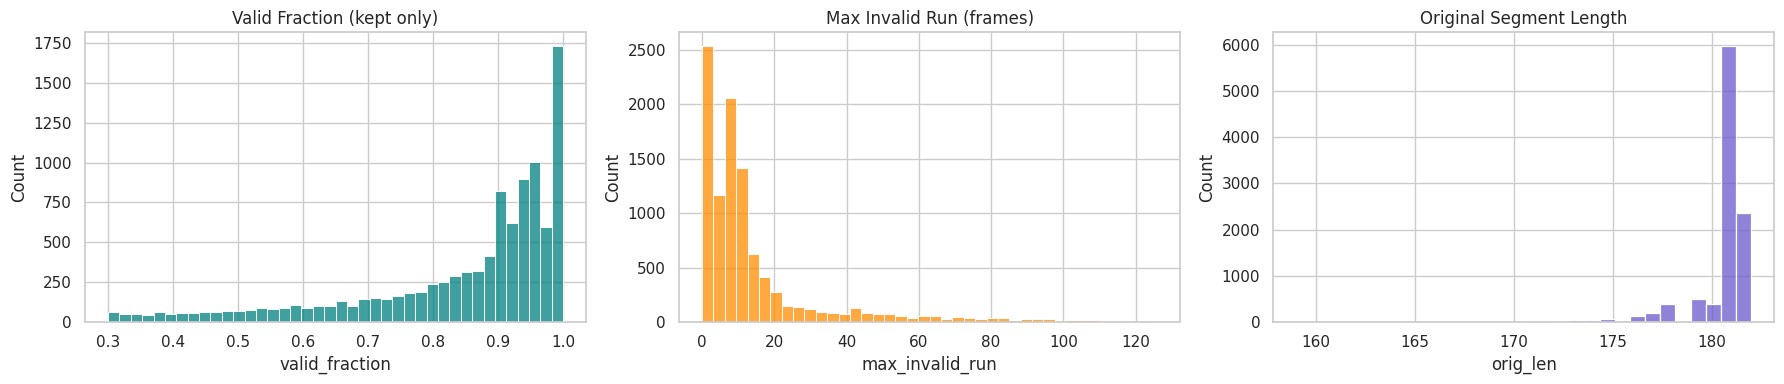

In [58]:
display(kept[['orig_len', 'pad_len', 'valid_fraction', 'max_invalid_run']].describe().T)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(kept['valid_fraction'], bins=40, ax=axes[0], color='teal')
axes[0].set_title('Valid Fraction (kept only)')

sns.histplot(kept['max_invalid_run'], bins=40, ax=axes[1], color='darkorange')
axes[1].set_title('Max Invalid Run (frames)')

sns.histplot(kept['orig_len'], bins=30, ax=axes[2], color='slateblue')
axes[2].set_title('Original Segment Length')
plt.tight_layout()


In [59]:
drop_counts = dropped['drop_reason'].value_counts().rename_axis('drop_reason').reset_index(name='count')
print('Drop reasons:')
display(drop_counts)


Drop reasons:


,drop_reason,count
0,low_valid_fraction,7253


## Label and Subject Distribution

n_labels (binary): 2
n_subjects: 25


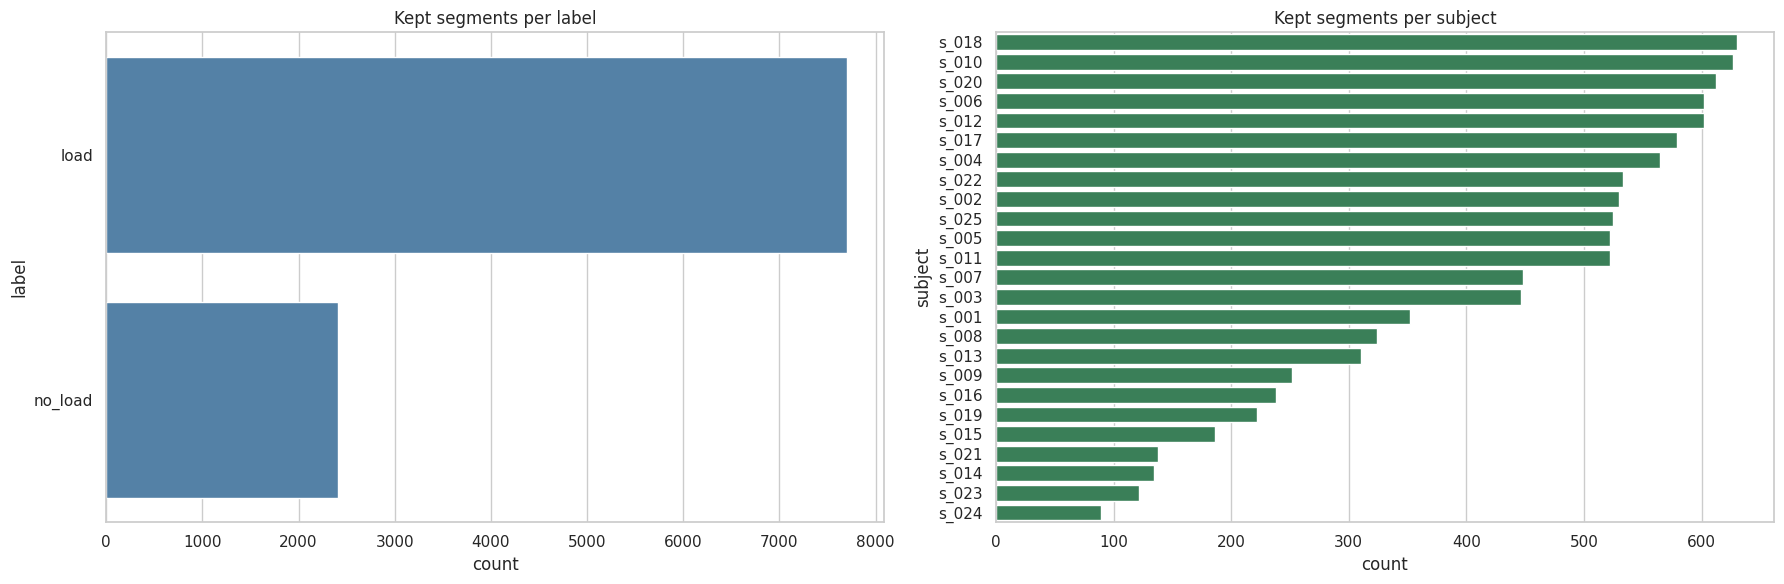

In [60]:
label_counts = kept['analysis_label'].value_counts()
subject_counts = kept['Subject'].value_counts()

print(f'n_labels ({LABEL_SCHEME}):', label_counts.size)
print('n_subjects:', subject_counts.size)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=label_counts.values, y=label_counts.index, ax=axes[0], color='steelblue')
axes[0].set_title('Kept segments per label')
axes[0].set_xlabel('count')
axes[0].set_ylabel('label')

sns.barplot(x=subject_counts.values, y=subject_counts.index, ax=axes[1], color='seagreen')
axes[1].set_title('Kept segments per subject')
axes[1].set_xlabel('count')
axes[1].set_ylabel('subject')

plt.tight_layout()


,analysis_label,n,valid_fraction_mean,valid_fraction_median,max_invalid_run_mean
0,load,7704,0.856604,0.917127,13.534138
1,no_load,2406,0.807319,0.872928,16.974647


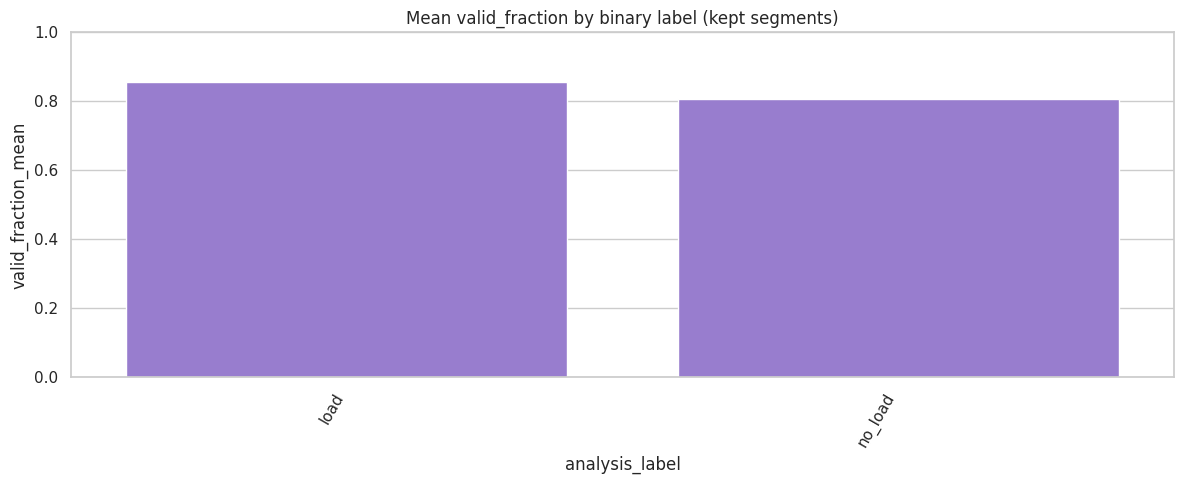

In [61]:
# QC by label: are some tasks lower quality?
qc_by_label = (
    kept.groupby('analysis_label', as_index=False)
    .agg(
        n=('segment_id', 'count'),
        valid_fraction_mean=('valid_fraction', 'mean'),
        valid_fraction_median=('valid_fraction', 'median'),
        max_invalid_run_mean=('max_invalid_run', 'mean'),
    )
    .sort_values('n', ascending=False)
)
display(qc_by_label)

fig, ax = plt.subplots(figsize=(12, 5))
plot_df = qc_by_label.sort_values('valid_fraction_mean', ascending=False)
sns.barplot(data=plot_df, x='analysis_label', y='valid_fraction_mean', ax=ax, color='mediumpurple')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.set_title(f'Mean valid_fraction by {LABEL_SCHEME} label (kept segments)')
ax.set_ylim(0, 1)
plt.tight_layout()


## Embedding-Space Sanity Checks

norm stats: {'count': 10110.0, 'mean': 2.663569211959839, 'std': 0.039672188460826874, 'min': 2.4798943996429443, '25%': 2.6379207372665405, '50%': 2.6655056476593018, '75%': 2.6910414695739746, 'max': 2.8739066123962402}


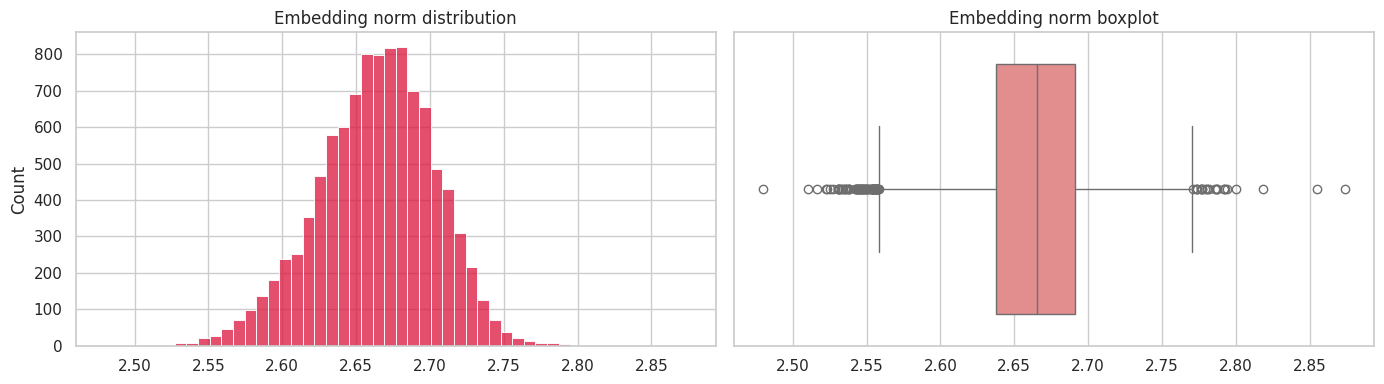

In [62]:
emb_norm = np.linalg.norm(X, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(emb_norm, bins=50, ax=axes[0], color='crimson')
axes[0].set_title('Embedding norm distribution')

sns.boxplot(x=emb_norm, ax=axes[1], color='lightcoral')
axes[1].set_title('Embedding norm boxplot')

plt.tight_layout()
print('norm stats:', pd.Series(emb_norm).describe().to_dict())


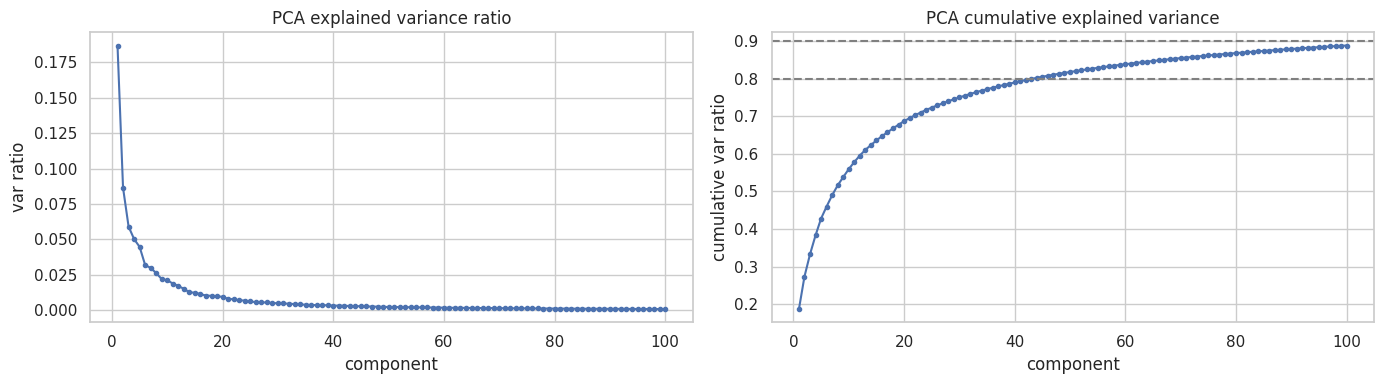

In [63]:
# PCA explained variance
pca_full = PCA(n_components=min(100, X.shape[1]), random_state=RNG)
_ = pca_full.fit(X)
expl = pca_full.explained_variance_ratio_
cum_expl = np.cumsum(expl)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(np.arange(1, len(expl)+1), expl, marker='o', markersize=3)
axes[0].set_title('PCA explained variance ratio')
axes[0].set_xlabel('component')
axes[0].set_ylabel('var ratio')

axes[1].plot(np.arange(1, len(cum_expl)+1), cum_expl, marker='o', markersize=3)
axes[1].axhline(0.8, color='gray', linestyle='--')
axes[1].axhline(0.9, color='gray', linestyle='--')
axes[1].set_title('PCA cumulative explained variance')
axes[1].set_xlabel('component')
axes[1].set_ylabel('cumulative var ratio')

plt.tight_layout()


PCA2 explained variance: 0.2735183


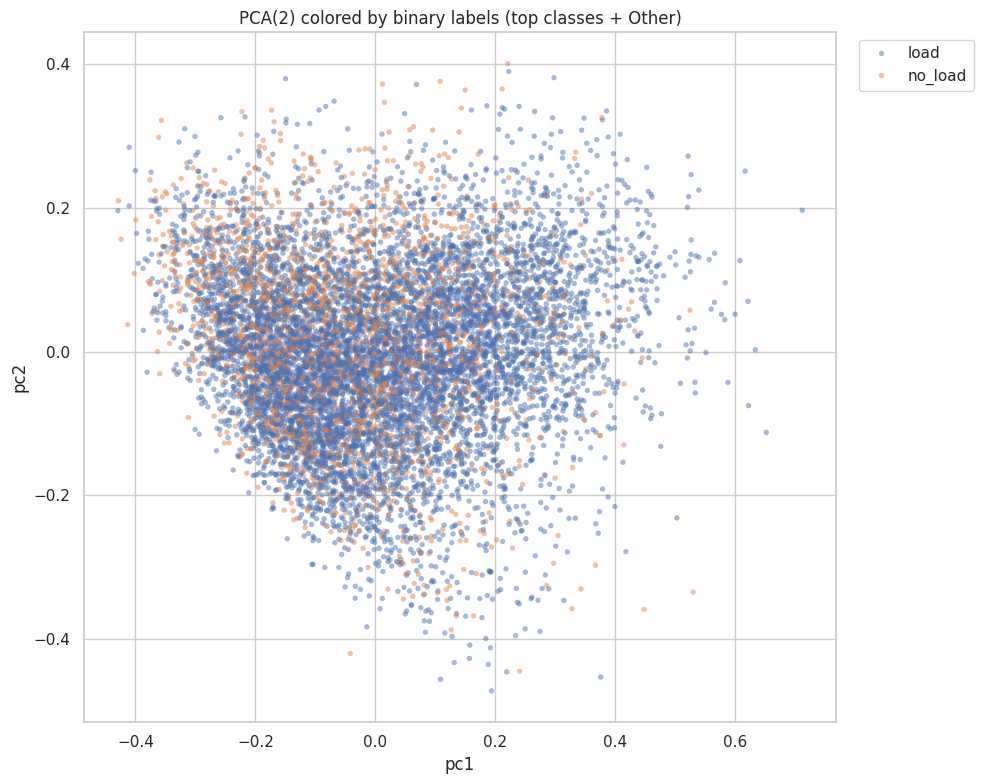

In [64]:
# 2D PCA view (top labels + Other)
TOP_K = 8
top_labels = kept['analysis_label'].value_counts().head(TOP_K).index
plot_label = kept['analysis_label'].where(kept['analysis_label'].isin(top_labels), other='Other')

pca2 = PCA(n_components=2, random_state=RNG)
X2 = pca2.fit_transform(X)
plot_df = pd.DataFrame({
    'pc1': X2[:, 0],
    'pc2': X2[:, 1],
    'LabelPlot': plot_label.values,
    'Subject': kept['Subject'].values,
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='pc1', y='pc2', hue='LabelPlot', alpha=0.5, s=15, linewidth=0)
plt.title(f'PCA(2) colored by {LABEL_SCHEME} labels (top classes + Other)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
print('PCA2 explained variance:', pca2.explained_variance_ratio_.sum())


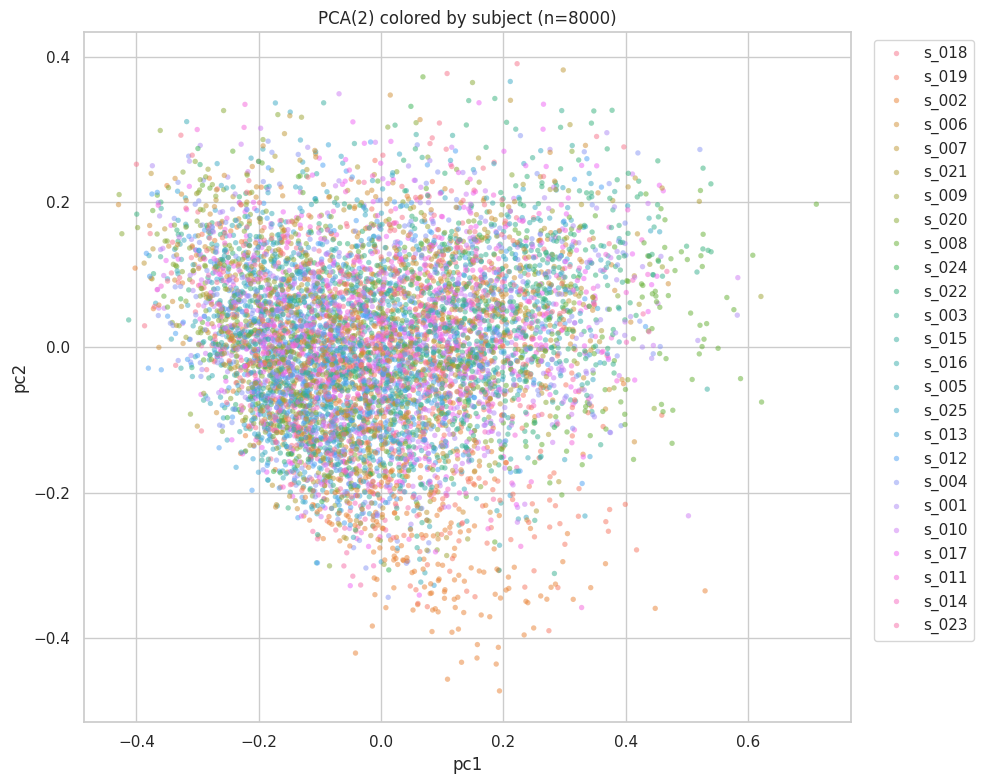

In [65]:
# 2D PCA colored by subject (sampled for readability)
max_points = 8000
if len(plot_df) > max_points:
    idx = np.random.default_rng(RNG).choice(len(plot_df), size=max_points, replace=False)
    sub_df = plot_df.iloc[idx].copy()
else:
    sub_df = plot_df.copy()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=sub_df, x='pc1', y='pc2', hue='Subject', alpha=0.5, s=15, linewidth=0)
plt.title(f'PCA(2) colored by subject (n={len(sub_df)})')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)
plt.tight_layout()


## Class-Separability Diagnostics

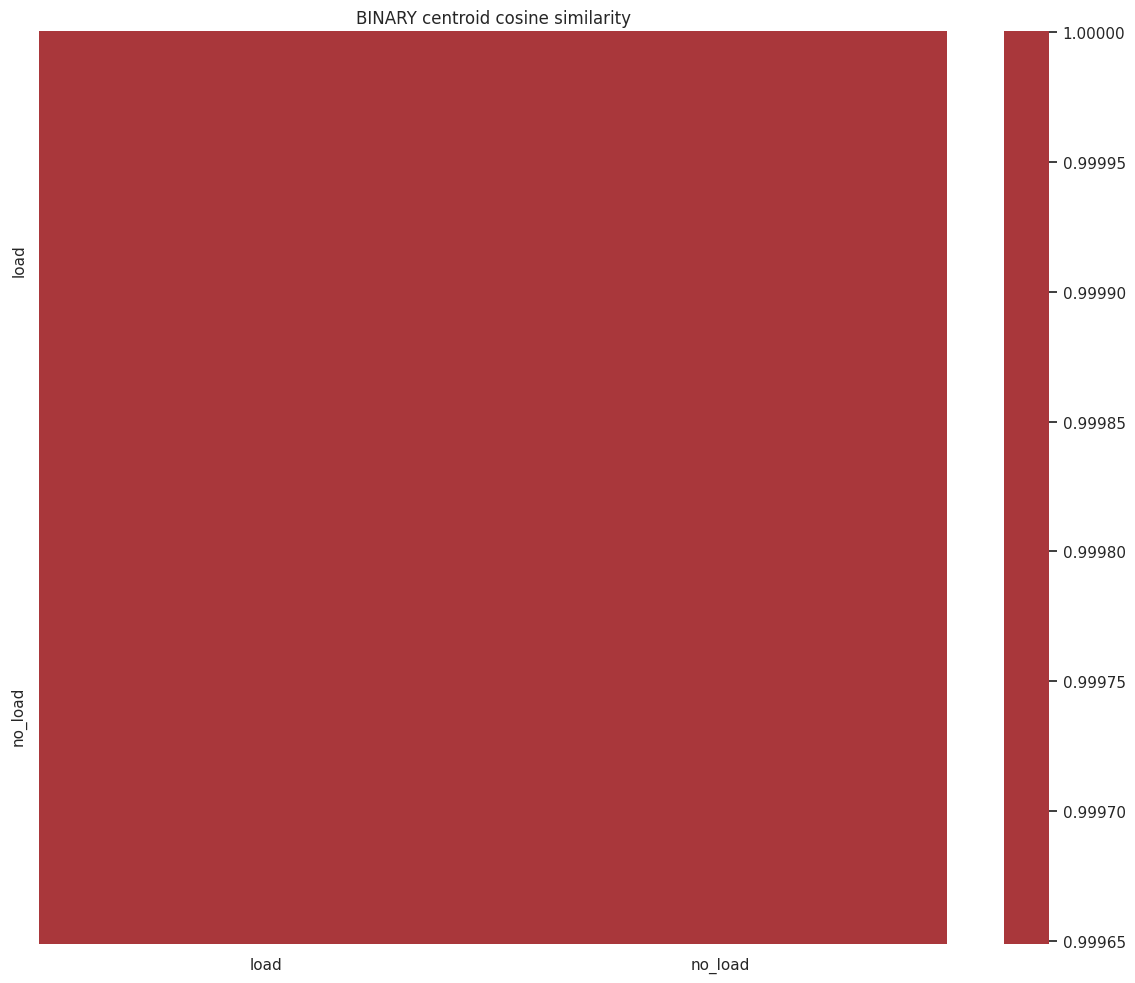

In [66]:
# Cosine similarity between label centroids (higher is more similar)
labels = kept['analysis_label'].to_numpy()
unique_labels = np.array(sorted(pd.unique(labels)))
centroids = []
for lbl in unique_labels:
    centroids.append(X[labels == lbl].mean(axis=0))
C = np.vstack(centroids)

# normalize for cosine sim
C_norm = C / (np.linalg.norm(C, axis=1, keepdims=True) + 1e-12)
cos_sim = C_norm @ C_norm.T

sim_df = pd.DataFrame(cos_sim, index=unique_labels, columns=unique_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(sim_df, cmap='vlag', center=0.0)
plt.title(f'{LABEL_SCHEME.upper()} centroid cosine similarity')
plt.tight_layout()


In [67]:
# Linear probe with GroupKFold (group by subject and by recording)
le = LabelEncoder()
y = le.fit_transform(kept['analysis_label'].to_numpy())

# Recording-level grouping; in this dataset often one recording per subject,
# but we keep this explicit for portability to multi-recording datasets.
recording_group = (kept['Path'].astype(str) + '/' + kept['Filename'].astype(str)).to_numpy()
subject_group = kept['Subject'].astype(str).to_numpy()

base_clf = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None)
)

def evaluate_groupkfold(
    X_eval: np.ndarray,
    y_eval: np.ndarray,
    groups: np.ndarray,
    grouping_name: str,
    estimator,
    max_splits: int = 5,
) -> dict:
    n_groups = len(np.unique(groups))
    n_splits = min(max_splits, n_groups)
    if n_splits < 2:
        raise ValueError(f'[{grouping_name}] Need at least 2 groups, got {n_groups}.')

    gkf = GroupKFold(n_splits=n_splits)
    acc_scores = []
    bal_acc_scores = []

    for fold_idx, (tr, te) in enumerate(gkf.split(X_eval, y_eval, groups=groups), start=1):
        y_tr = y_eval[tr]
        y_te = y_eval[te]

        # Guard pathological folds in small/quick subsets
        if len(np.unique(y_tr)) < 2 or len(np.unique(y_te)) < 2:
            print(f'[{grouping_name}] skipping fold {fold_idx}: insufficient class diversity')
            continue

        model = clone(estimator)
        model.fit(X_eval[tr], y_tr)
        y_hat = model.predict(X_eval[te])

        acc_scores.append(accuracy_score(y_te, y_hat))
        bal_acc_scores.append(balanced_accuracy_score(y_te, y_hat))

    if not acc_scores:
        raise RuntimeError(f'[{grouping_name}] No valid folds after class-diversity filtering.')

    return {
        'grouping': grouping_name,
        'n_groups': n_groups,
        'n_folds_used': len(acc_scores),
        'accuracy_mean': float(np.mean(acc_scores)),
        'accuracy_std': float(np.std(acc_scores)),
        'balanced_accuracy_mean': float(np.mean(bal_acc_scores)),
        'balanced_accuracy_std': float(np.std(bal_acc_scores)),
    }

results_grouped = [
    evaluate_groupkfold(X, y, subject_group, 'subject', base_clf, max_splits=5),
    evaluate_groupkfold(X, y, recording_group, 'recording', base_clf, max_splits=5),
]

results_grouped_df = pd.DataFrame(results_grouped).sort_values('balanced_accuracy_mean', ascending=False)
display(results_grouped_df)


,grouping,n_groups,n_folds_used,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std
0,subject,25,5,0.630562,0.036098,0.607731,0.012702
1,recording,25,5,0.630562,0.036098,0.607731,0.012702


In [68]:
# Robustness experiment: all-kept vs removing lowest valid_fraction quartile
q25 = float(kept['valid_fraction'].quantile(0.25))
keep_mask_top75 = kept['valid_fraction'].to_numpy() > q25

print(f'valid_fraction 25th percentile threshold: {q25:.4f}')
print(f'all-kept n={len(kept)} | top-75% n={int(keep_mask_top75.sum())}')

X_top75 = X[keep_mask_top75]
y_top75 = y[keep_mask_top75]
subject_top75 = subject_group[keep_mask_top75]
recording_top75 = recording_group[keep_mask_top75]

robust_results = []

# All kept
robust_results.append({
    'dataset': 'all_kept',
    **evaluate_groupkfold(X, y, subject_group, 'subject', base_clf, max_splits=5)
})
robust_results.append({
    'dataset': 'all_kept',
    **evaluate_groupkfold(X, y, recording_group, 'recording', base_clf, max_splits=5)
})

# Top 75% valid_fraction
robust_results.append({
    'dataset': 'top75_valid_fraction',
    **evaluate_groupkfold(X_top75, y_top75, subject_top75, 'subject', base_clf, max_splits=5)
})
robust_results.append({
    'dataset': 'top75_valid_fraction',
    **evaluate_groupkfold(X_top75, y_top75, recording_top75, 'recording', base_clf, max_splits=5)
})

robust_df = pd.DataFrame(robust_results)
robust_df = robust_df[[
    'dataset', 'grouping', 'n_groups', 'n_folds_used',
    'accuracy_mean', 'accuracy_std',
    'balanced_accuracy_mean', 'balanced_accuracy_std'
]].sort_values(['grouping', 'dataset'])
display(robust_df)

# Compact delta view: top75 - all_kept
pivot = robust_df.pivot(index='grouping', columns='dataset', values='balanced_accuracy_mean')
if {'all_kept', 'top75_valid_fraction'}.issubset(pivot.columns):
    delta = (pivot['top75_valid_fraction'] - pivot['all_kept']).rename('delta_bal_acc_top75_minus_all')
    display(delta.to_frame())


valid_fraction 25th percentile threshold: 0.7802
all-kept n=10110 | top-75% n=7578


,dataset,grouping,n_groups,n_folds_used,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std
1,all_kept,recording,25,5,0.630562,0.036098,0.607731,0.012702
3,top75_valid_fraction,recording,25,5,0.648046,0.038483,0.604929,0.027139
0,all_kept,subject,25,5,0.630562,0.036098,0.607731,0.012702
2,top75_valid_fraction,subject,25,5,0.648046,0.038483,0.604929,0.027139


,delta_bal_acc_top75_minus_all
grouping,
recording,-0.002801
subject,-0.002801


Holdout split classes: train=2, test=2


,model,accuracy,balanced_accuracy
0,LogisticRegression,0.649852,0.632992
1,MeanCentroid,0.583086,0.582754
2,LightGBM,0.767557,0.540036


Best by balanced_accuracy: LogisticRegression
              precision    recall  f1-score   support

        load       0.84      0.67      0.74      1541
     no_load       0.36      0.60      0.45       481

    accuracy                           0.65      2022
   macro avg       0.60      0.63      0.60      2022
weighted avg       0.73      0.65      0.67      2022



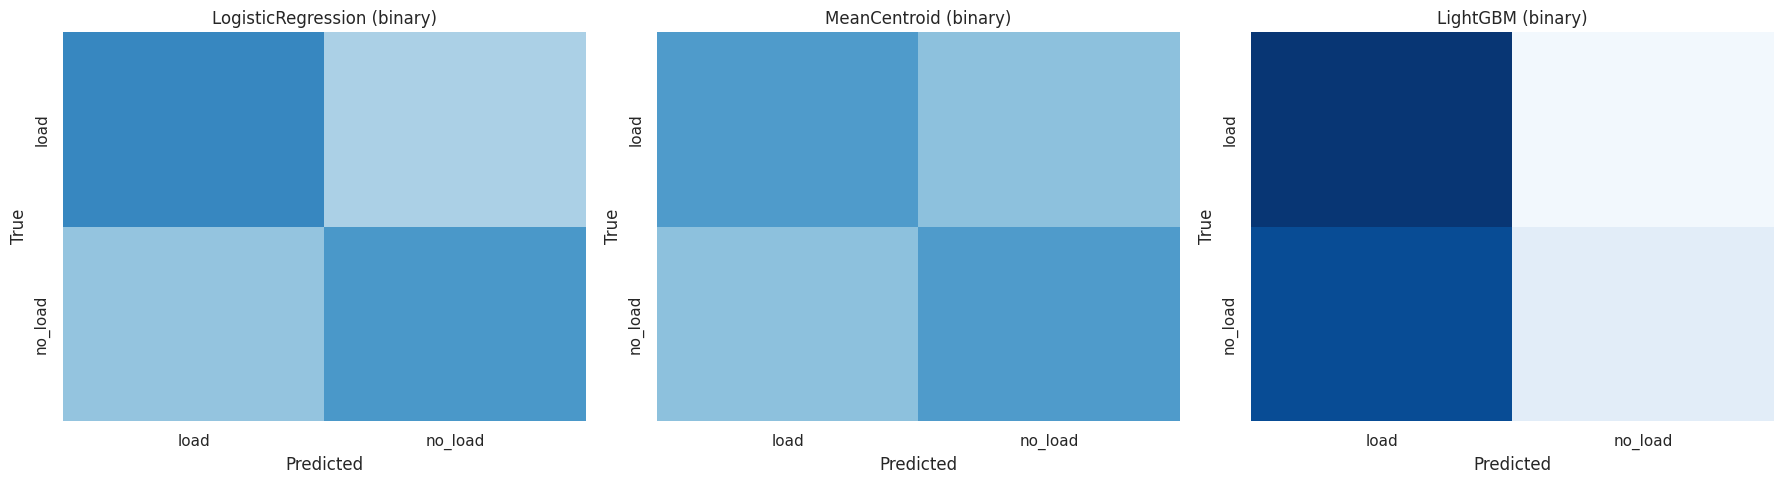

In [69]:
# Holdout split: compare Logistic Regression, Mean-Centroid, and LightGBM
from sklearn.model_selection import train_test_split

n_classes_total = len(np.unique(y))
if n_classes_total < 2:
    raise ValueError(
        f'Need at least 2 classes for holdout classification, got {n_classes_total}. '
        'Try disabling QUICK_SANITY_MODE or switching LABEL_SCHEME.'
    )

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG, stratify=y
)

n_classes_train = len(np.unique(y_train))
print(f'Holdout split classes: train={n_classes_train}, test={len(np.unique(y_test))}')

models = {
    'LogisticRegression': make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(max_iter=2000, class_weight='balanced')
    ),
    'MeanCentroid': make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        NearestCentroid()
    ),
}

try:
    import lightgbm as lgb
    lgb_params = dict(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RNG,
        verbosity=-1,
    )
    if n_classes_train == 2:
        lgb_params['objective'] = 'binary'
    else:
        lgb_params['objective'] = 'multiclass'
        lgb_params['num_class'] = n_classes_train

    models['LightGBM'] = lgb.LGBMClassifier(**lgb_params)
except ImportError:
    print('lightgbm not installed; skipping LightGBM baseline in holdout comparison.')

results = []
confusions = {}
fitted_models = {}
for model_name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        results.append({'model': model_name, 'accuracy': acc, 'balanced_accuracy': bal_acc})
        confusions[model_name] = confusion_matrix(y_test, y_pred, normalize='true')
        fitted_models[model_name] = model
    except Exception as exc:
        print(f'Skipping {model_name} due to error: {exc}')

if not results:
    raise RuntimeError('No model could be trained successfully on the current split.')

results_df = pd.DataFrame(results).sort_values('balanced_accuracy', ascending=False).reset_index(drop=True)
display(results_df)

best_model_name = results_df.iloc[0]['model']
y_pred_best = fitted_models[best_model_name].predict(X_test)
present_labels = np.unique(np.concatenate([y_test, y_pred_best]))
present_names = le.inverse_transform(present_labels)

print(f'Best by balanced_accuracy: {best_model_name}')
print(classification_report(y_test, y_pred_best, labels=present_labels, target_names=present_names))

fig, axes = plt.subplots(1, len(confusions), figsize=(6 * len(confusions), 5), squeeze=False)
for ax, (model_name, cm) in zip(axes.ravel(), confusions.items()):
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    sns.heatmap(cm_df, cmap='Blues', vmin=0, vmax=1, ax=ax, cbar=False)
    ax.set_title(f'{model_name} ({LABEL_SCHEME})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()


## What to inspect next

- Subject leakage risk: evaluate group-aware split (`GroupKFold`) by `Subject`.
- Robustness: rerun probe after removing lowest `valid_fraction` quartile.
- Task-family separability: merge labels into broader cognitive task groups and repeat analyses.
- Embedding stability: compare with different MOMENT checkpoints (`small/base/large`) and reductions.
